## PreProcessing Steps :

In [1]:
#!pip3 install gensim
import time
start = time.time()

#Importing libraries:
import sqlite3 as sql
import seaborn as sns
import datetime
import gensim
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#it helps the output of plotting commands is displayed inline in Jupyter notebook directly below the cell on which op was run.
import re
import pickle
end = time.time()
print('execution time is {:.3f} Minutes'.format(((end - start) / 60)))

execution time is 0.053 Minutes


**Loading data**

In [2]:
#Using sqlite3 to retrieve data from sqlite file
start = time.time()
con = sql.connect("database.sqlite")#Connection object that represents the database

#Using pandas functions to query from sql table
df = pd.read_sql_query("""SELECT * FROM Reviews  where "Score" !=3 """,con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head(2)
end = time.time()
print('execution time is {:.3f} Minutes'.format(((end - start) / 60)))

execution time is 0.065 Minutes


In [3]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64

CPU times: user 1.94 s, sys: 56 ms, total: 2 s
Wall time: 2 s


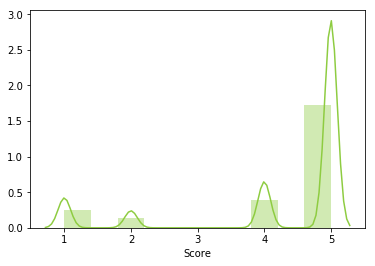

In [4]:
%%time
#to check the distibutions of the column 'Score'
sns.distplot(df['Score'], bins=10, color="#8ecc41")

**DataCleaning Steps**

In [5]:
print(df.duplicated(subset={"UserId","ProfileName","Time","Text"}).head(5))
print()
print('total no of duplicate rows based on columns are:\n{}'.format(df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()))

0    False
1    False
2    False
3    False
4    False
dtype: bool

total no of duplicate rows based on columns are:
False    364173
True     161641
dtype: int64


In [6]:
#removing duplicates:
df = df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first')
print(len(df))

364173


In [7]:
df = df[df['HelpfulnessNumerator'] <= df.HelpfulnessDenominator]
print(len(df))

364171


In [8]:
df['Score'] = df['Score'].apply(lambda x: 'Positive' if x >3 else 'Negative')
df['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [9]:
#cerating a copy of deduplicated data to 'final' dataframe:
final = df.copy()

**Texual Data Preprocessing:**
1.  Removing HTML tags
2.  Removing puncuation marks/special characters
3.  Conversion of all reviews to lower characters

In [10]:
%%time
# removeing HTML TAG
final['Text'] = final['Text'].apply(lambda x : re.sub('<.*?>',' ', x)) #No characters to be substitited in place of HTML tag

#removing punctuation marks:
final['Text'] = final['Text'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]', ' ', x))

#converting it to lower case:
final['Text'] = final['Text'].apply(lambda x: x.lower())

CPU times: user 4.33 s, sys: 88 ms, total: 4.42 s
Wall time: 4.43 s


**StopWords creation:**

In [11]:
%%time

#supporting libraries for creating stopwords:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


#creating stopwords list:

stop = set(stopwords.words('english')) #set of stopwords
stop = list(stop)
temp = []
list_of_excluded_words = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


for i in range(len(stop)):
    if stop[i] in list_of_excluded_words:
        continue
    else:
        temp.append(stop[i])
stop = set(temp)
print(stop)

{'other', 'll', 'more', 'between', 'was', 'm', 'each', 'just', "shan't", 'once', 'while', 'myself', 'too', 'same', 'such', 'o', 'ma', "should've", 'below', 'have', 'very', 'to', 'again', 'through', 'be', 'over', 'i', 'them', 'its', 'down', 'few', 'off', 'with', 'why', 'only', 'ourselves', 'who', 'out', 'no', 'we', 'than', 'their', 'itself', 'these', 'up', 'here', 'at', "that'll", "it's", 'by', 'for', "you'll", 'a', 'they', 't', 'theirs', 'd', 'doing', 'from', 'herself', 'if', 'or', 'nor', 'it', 'will', 'whom', 'ours', 'yours', 'of', 'own', 'hers', 'when', 'about', 'most', 'is', "you're", 'and', 'the', 'which', 'did', 'our', 'because', 'into', 'y', 'before', "she's", 'do', 'your', 'during', 'in', 'this', 'all', 'those', 'she', 'on', 'you', 'been', 'my', 'themselves', 'can', 'both', 'where', 'an', 'so', 'he', 'are', 'me', 'does', 'yourselves', 'him', 'were', 'should', 's', 'further', 'as', 'some', 'after', "you'd", 'having', "you've", 'then', 'himself', 'there', 'any', 'her', 'had', 'wha

In [12]:
#nltk.download()

## Stemming:

**Porter Stemmer: Most commonly used stemmer. But it is also the most computationally intensive algorithms. It is also the oldest stemming algorithm.**

**SnowBall Stemmer: it is regarded as an improvement over porter. Slightly faster computation time than Porter stemmer.**

In [13]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:\n")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('New Delhi'))

Stem/Root words of the some of the words using SnowBall Stemmer:

tasti
tast
tastiest
new delhi


**BoW - Preprocessing - single review**

In [14]:
%%time

#creating list of cleaned words and two seperate lists of pos & neg reviews
str1=''
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sentence in final['Text'][2:3].values:
    filtered_sentence=[]
    print(sentence)
    for word in sentence.split():
        print('..................................................>> {}'.format(word))
        if((word not in stop) & (len(word)>2) & (word.isalpha())):    
            s = snow.stem(word).encode('utf8')
            print('word after stemming is .........>> {}'.format(s))
            filtered_sentence.append(s)                   
        else:
            print('{} eliminated' .format(word))
            continue
            
#print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("*" * 40)
    
    final_string.append(str1)

this is a confection that has been around a few centuries   it is a light  pillowy citrus gelatin with nuts - in this case filberts  and it is cut into tiny squares and then liberally coated with powdered sugar   and it is a tiny mouthful of heaven   not too chewy  and very flavorful   i highly recommend this yummy treat   if you are familiar with the story of c s  lewis   the lion  the witch  and the wardrobe  - this is the treat that seduces edmund into selling out his brother and sisters to the witch 
..................................................>> this
this eliminated
..................................................>> is
is eliminated
..................................................>> a
a eliminated
..................................................>> confection
word after stemming is .........>> b'confect'
..................................................>> that
that eliminated
..................................................>> has
has eliminated
......................

**BoW  Preprocessing - All Reviews:**

In [15]:
start = time.time()

#creating list of cleaned words and two seperate lists of pos & neg reviews
i = 0
str1 = ''
final_string = []
all_positive_words = [] # store words from +ve reviews here
all_negative_words = [] # store words from -ve reviews here.
s = ''
for sentence in final['Text'].values:
    filtered_sentence = []
    for word in sentence.split():
        if((word not in stop) & (len(word)>2) & (word.isalpha())):    
            s = snow.stem(word).encode('utf8')
            filtered_sentence.append(s)
            if (final['Score'].values)[i] == 'Positive': 
                all_positive_words.append(s) #list of all words used to describe positive reviews
            elif(final['Score'].values)[i] == 'Negative':
                all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        else:
            continue
 #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("*" * 40)
    
    final_string.append(str1)
    i+=1 
end = time.time()
print('time elapsed is {:<.3f} minutes'.format((end - start) / 60))

time elapsed is 5.292 minutes


In [16]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

**W2V and TFidf Preprocessing** 

In [17]:
%%time
final = df
# removeing HTML TAG
final['Text'] = final['Text'].apply(lambda x : re.sub('<.*?>',' ', x)) #No characters to be substitited in place of HTML tag

#removing punctuation marks:
final['Text'] = final['Text'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]', ' ', x))

#converting it to lower case:
final['Text'] = final['Text'].apply(lambda x: x.lower())

#creating the list of cleaned words(without stemming and lemmatization for W2V):

i = 0
str_w2v = ' '
final_string_w2v = []
s = ''
for sentence in final['Text'].values:
    filtered_sentence=[]
    for word in sentence.split():
        if((len(word) > 2) & (word.isalpha()) & (word not in stop)):    
            s = word.encode('utf8')
            filtered_sentence.append(s)
        else:
            continue
 #print(filtered_sentence)
    str_w2v = b" ".join(filtered_sentence) #final string of cleaned words
    final_string_w2v.append(str_w2v)
    i+=1

CPU times: user 22 s, sys: 4 ms, total: 22 s
Wall time: 22 s


**BoW & TFidf - cleaned data columns creation**

In [18]:
final['CleanedText_Bow'] = final_string
final['ClenedText_W2Vtfdf'] = final_string_w2v
final['CleanedText_Bow'] = final['CleanedText_Bow'].apply(lambda x: x.decode("utf-8"))
final['ClenedText_W2Vtfdf'] = final['ClenedText_W2Vtfdf'].apply(lambda x: x.decode("utf-8"))
final.iloc[:, -2:].head(4)

,CleanedText_Bow,ClenedText_W2Vtfdf
0,bought sever vital can dog food product found ...,bought several vitality canned dog food produc...
1,product arriv label jumbo salt peanut peanut a...,product arrived labeled jumbo salted peanuts p...
2,confect around centuri light pillowi citrus ge...,confection around centuries light pillowy citr...
3,look secret ingredi robitussin believ found go...,looking secret ingredient robitussin believe f...


In [19]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText_Bow', 'ClenedText_W2Vtfdf'],
      dtype='object')

In [20]:
final['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [21]:
final['Score'] = final['Score'].apply(lambda x: 1 if x == 'Positive' else 0)
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

**sorting dataframe on 'Time' column,sample 1L sorted datapoints & saving dataFrame onto disc**

In [22]:
final = final.sort_values('Time')
final_1L = final.iloc[0:100000, ]
final_1L.to_csv('final_1L.csv', index=False)

In [23]:
final_1L.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText_Bow', 'ClenedText_W2Vtfdf'],
      dtype='object')

**BoW - Train, Test & CV splits:**

In [24]:
%%time

#train-test split:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

X_train, X_test, y_train, y_test = train_test_split(final_1L['CleanedText_Bow'].values, final_1L['Score'].values, 
                                                    test_size = 0.2, shuffle=False)
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14 ms


In [25]:
print('length of X_tr is {} y_tr is {}'.format(len(X_tr), len(y_tr)))
print('length of X_cv is {} y_cv is {}'.format(len(X_cv), len(y_cv)))
print('length of X_test is {} y_test is {}'.format(len(X_test), len(y_test)))

length of X_tr is 64000 y_tr is 64000
length of X_cv is 16000 y_cv is 16000
length of X_test is 20000 y_test is 20000


**BoW - splitted datapoints into pickled file and saving onto disc:**

In [26]:
#pickeling splitted data points to disk:

bow_list = [X_tr, X_cv, X_test]
file1 = open('bow_splitted_dataPoints.pickle','wb')

# dump information to that file
pickle.dump(bow_list, file1)

# close the file
file1.close()

class_label = [y_tr, y_cv, y_test]
file1 = open('class_label.pickle', 'wb')

# dump information to that file
pickle.dump(class_label, file1)

# close the file
file1.close()

**W2V, TFidf - Train, Test, CV splits:**

In [27]:
#train-test split:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_1L['ClenedText_W2Vtfdf'].values, final_1L['Score'].values, 
                                                    test_size = 0.2, shuffle=False)
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

**W2V, TFIDF -  splitted datapoints into pickled file and saving onto disc:**

In [28]:
#pickeling splitted data points to disk:

w2v_list = [X_tr, X_cv, X_test]

# open a file object, to store the data
file1 = open('w2v_splitted_datapoints.pickle', 'wb')

# dump information to that file
pickle.dump(w2v_list, file1)

# close the file
file1.close()

**W2V - creating document corpus of reviews for X_train ,X_cv, X_test**

In [29]:
%%time
file1 = open('w2v_splitted_datapoints.pickle','rb')
w2v_list = pickle.load(file1)
X_tr, X_cv, X_test = w2v_list[0], w2v_list[1], w2v_list[2]
file1.close()

#creating list of lists(list of words in sentence of sentences) for X_tr
w_train = []
s = ''
for sentence in X_tr:
    sentence_list = []
    for words in sentence.split():
        s = words
        sentence_list.append(s)
    w_train.append(sentence_list)

cnt = 0
for i in w_train:
    print(i)
    cnt = cnt + 1
    if cnt == 1:
        break
print(len(w_train))

['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'love', 'new', 'words', 'book', 'introduces', 'silliness', 'classic', 'book', 'willing', 'bet', 'son', 'still', 'able', 'recite', 'memory', 'college']
64000
CPU times: user 1.18 s, sys: 72 ms, total: 1.26 s
Wall time: 1.31 s


In [30]:
%%time

#creating list of lists(list of words in sentence of sentences) for X_cv:
w_cv = []
s = ''
for sentence in X_cv:
    sentence_list = []
    for words in sentence.split():
        s = words
        sentence_list.append(s)
    w_cv.append(sentence_list)


#to check first review
cnt = 0
for j in w_cv:
    print(j)
    cnt = cnt + 1
    if cnt == 1:
        break
print(len(X_cv))

['need', 'find', 'good', 'egg', 'substitute', 'allergic', 'family', 'members', 'enjoy', 'cake', 'tried', 'powder', 'egg', 'replacer', 'didn', 'work', 'tried', 'extra', 'baking', 'powder', 'tried', 'applesauce', 'flax', 'seeds', 'etc', 'nothing', 'worked', 'help']
16000
CPU times: user 152 ms, sys: 28 ms, total: 180 ms
Wall time: 182 ms


In [31]:
%%time

#creating list of lists(list of words in sentence of sentences) for X_test:
w_test = []
s = ''
for sentence in X_test:
    sentence_list = []
    for words in sentence.split():
        s = words
        sentence_list.append(s)
    w_test.append(sentence_list)
     
#to check first review 
cnt = 0
for j in w_test:
    print(j)
    cnt = cnt + 1
    if cnt == 1:
        break
print(len(w_test))

['product', 'great', 'taste', 'italy', 'wonderful', 'almost', 'cheese', 'slight', 'drizzle', 'brie', 'chedder', 'cheese', 'love']
20000
CPU times: user 200 ms, sys: 24 ms, total: 224 ms
Wall time: 223 ms


**W2V - pickeling list of data points and saving onto disc**

In [33]:
w2v_ListOfSentence = [w_train, w_cv, w_test]

file = open('w2v_ListOfSentence.pickle', '+wb')
pickle.dump(w2v_ListOfSentence, file)
file.close()

## FeatureEngineering:

**BoW - Feature Engineering**

In [34]:
#checking for whether any column is haivng Null value?
final_1L.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
CleanedText_Bow           0
ClenedText_W2Vtfdf        0
dtype: int64

In [35]:
final_1L['Score'] = final_1L['Score'].apply(lambda x: 'Positive' if int(x) == 1 else 'Negative')
final_1L['Score'].value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [36]:
%%time
# removeing HTML TAG
final_1L['Summary'] = final_1L['Summary'] .apply(lambda x : re.sub('<.*?>',' ', x)) #No characters to be substitited in place of HTML tag

#removing punctuation marks:
final_1L['Summary']  = final_1L['Summary'] .apply(lambda x: re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]', ' ', x))

#converting it to lower case:
final_1L['Summary']  = final_1L['Summary'] .apply(lambda x: x.lower())

CPU times: user 420 ms, sys: 0 ns, total: 420 ms
Wall time: 426 ms


In [37]:
start = time.time()

#creating list of cleaned words and two seperate lists of pos & neg reviews
i = 0
str1 = ''
final_string = []
all_positive_words = [] # store words from +ve reviews here
all_negative_words = [] # store words from -ve reviews here.
s = ''
for sentence in final_1L['Summary'].values:
    filtered_sentence = []
    for word in sentence.split():
        if((word not in stop) & (len(word)>2) & (word.isalpha())):    
            s = snow.stem(word).encode('utf8')
            filtered_sentence.append(s)
            if (final_1L['Score'].values)[i] == 'Positive': 
                all_positive_words.append(s) #list of all words used to describe positive reviews
            elif(final_1L['Score'].values)[i] == 'Negative':
                all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        else:
            continue
 #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("*" * 40)
    
    final_string.append(str1)
    i+=1 
end = time.time()
print('time elapsed is {:<.3f} minutes'.format((end - start) / 60))

time elapsed is 0.112 minutes


In [38]:
final_1L['Bow_feat'] = final_string
final_1L['Bow_feat'] = final_1L['Bow_feat'].apply(lambda x: x.decode("utf-8"))

In [39]:
final_1L['Bow_feat'].head(4)

138706                          everi book educ
138683    whole seri great way spend time child
417839                      entertainingl funni
212472                    modern day fairi tale
Name: Bow_feat, dtype: object

**BoW - creating new featured column**

In [40]:
# replacing blank space of one of the cells of 'summary' which is having NaN value:
#final_1L['Summary'] = final_1L['Summary'].replace(np.nan, '', regex=True)

#creating new column of concatenation of two columns:
final_1L['Bow_new_feat'] = final_1L[['Bow_feat', 'CleanedText_Bow']].apply(lambda x: ' '.join(x),axis=1)
final_1L['Bow_new_feat'].head(2)

138706    everi book educ witti littl book make son laug...
138683    whole seri great way spend time child rememb s...
Name: Bow_new_feat, dtype: object

**W2V, TFidf - Feature engineering**

In [41]:
final_1L.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
CleanedText_Bow           0
ClenedText_W2Vtfdf        0
Bow_feat                  0
Bow_new_feat              0
dtype: int64

In [42]:
%%time
# removeing HTML TAG
final_1L['Summary'] = final_1L['Summary'] .apply(lambda x : re.sub('<.*?>',' ', x)) #No characters to be substitited in place of HTML tag

#removing punctuation marks:
final_1L['Summary']  = final_1L['Summary'] .apply(lambda x: re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]', ' ', x))

#converting it to lower case:
final_1L['Summary']  = final_1L['Summary'] .apply(lambda x: x.lower())

CPU times: user 272 ms, sys: 4 ms, total: 276 ms
Wall time: 280 ms


**W2V, TFidf : creating the list of cleaned words(without stemming and lemmatization) of 'Summary'  column**

In [43]:
%%time

i = 0
str_w2v = ' '
final_string_w2v = []
s = ''
for sentence in final_1L['Summary'].values:
    filtered_sentence=[]
    for word in sentence.split():
        if((len(word) > 2) & (word.isalpha()) & (word not in stop)):    
            s = word.encode('utf8')
            filtered_sentence.append(s)
        else:
            continue
 #print(filtered_sentence)
    str_w2v = b" ".join(filtered_sentence) #final string of cleaned words
    final_string_w2v.append(str_w2v)
    i+=1

CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 362 ms


**BoW, TFidf : New featured column creation:**

In [44]:
%%time

final_1L['w2v_feat'] = final_string_w2v
final_1L['w2v_feat'] = final_1L['w2v_feat'].apply(lambda x: x.decode("utf-8"))

# replacing blank space of one of the cells of 'summary' which is having NaN value:
#final_1L['Summary'] = final_1L['Summary'].replace(np.nan, '', regex=True)

#creating new column of concatenation of two columns:
final_1L['w2v_new_feat'] = final_1L[['w2v_feat', 'ClenedText_W2Vtfdf']].apply(lambda x: ' '.join(x),axis=1)
final_1L['w2v_new_feat'].head(2)

CPU times: user 2.33 s, sys: 0 ns, total: 2.33 s
Wall time: 2.34 s


138706    every book educational witty little book makes...
138683    whole series great way spend time child rememb...
Name: w2v_new_feat, dtype: object

In [45]:
final_1L['Score'].value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [46]:
final_1L['Score'] = final_1L['Score'].apply(lambda x: 1 if x == 'Positive' else 0)
final_1L['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

**Storing dataframe in table and saving into disc**

In [47]:
final_1L.to_csv('final_1L.csv', index=False)
import sqlite3
conn = sqlite3.connect('final_1L.sqlite')
final_1L.to_sql('reviews', conn,if_exists='replace') #dataframe is saved under table 'reviews'

In [51]:
#!pip3 install wordcloud

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

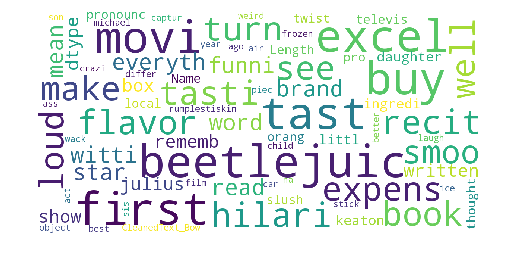

CPU times: user 572 ms, sys: 48 ms, total: 620 ms
Wall time: 631 ms


Series([], Name: CleanedText_Bow, dtype: object)

In [52]:
%%time

plt.rcParams['figure.figsize']=(8.0,6.0)
plt.Figure(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=42 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(final['CleanedText_Bow'])
final.loc[final['Score'] >3]['CleanedText_Bow']

In [53]:
pwd

'/home/reachjalesh/PreprocessingFolder'